In [1]:
!pip install pandas matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable


       request_throughput  output_throughput  total_token_throughput
count           50.000000          50.000000               50.000000
mean             3.604614        2678.401961             6365.921576
std              1.521437        1137.754075             2694.001396
min              0.912547         676.904195             1610.439285
25%              2.529602        1865.788666             4454.145910
50%              3.711590        2744.407010             6541.363333
75%              4.907789        3651.374353             8669.611305
max              6.053394        4568.956600            10761.578783


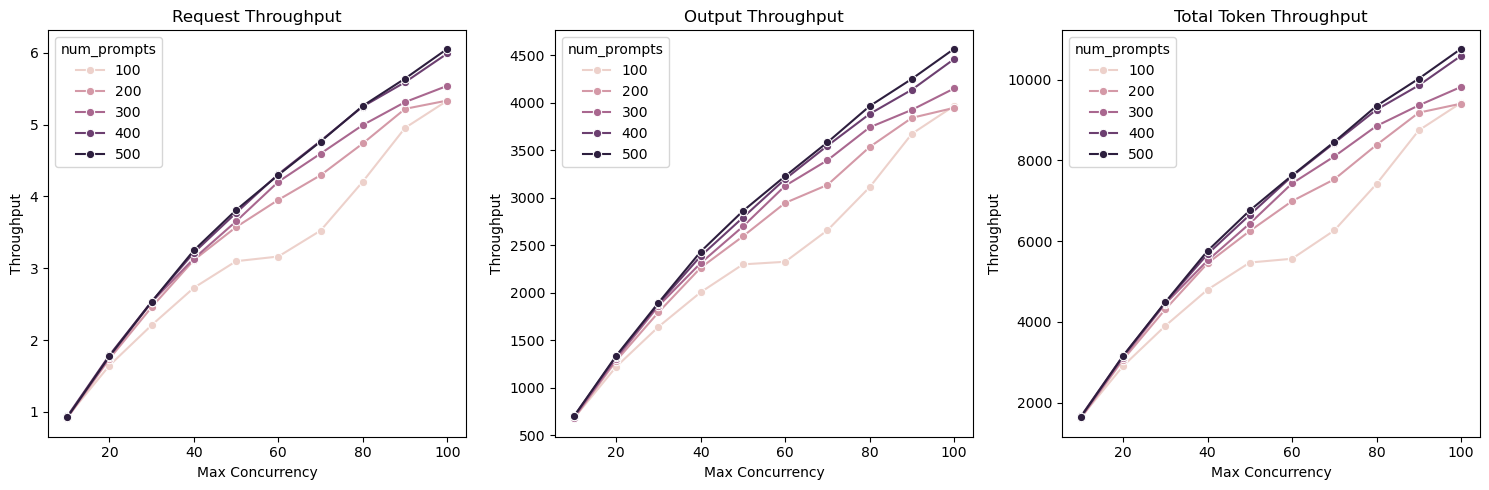

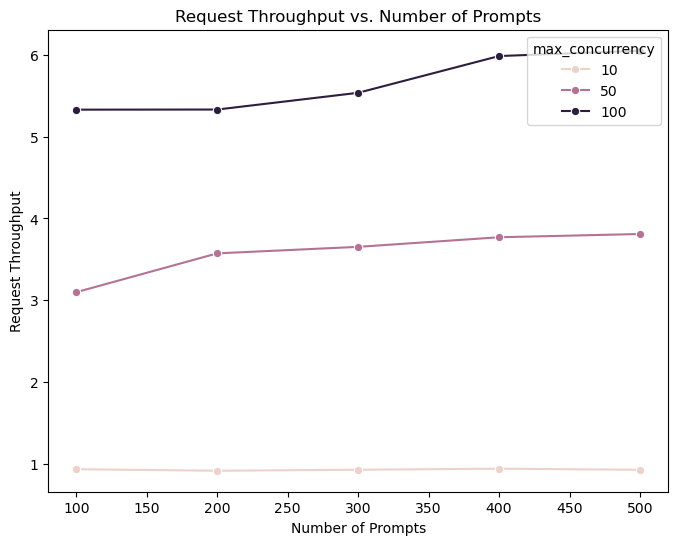

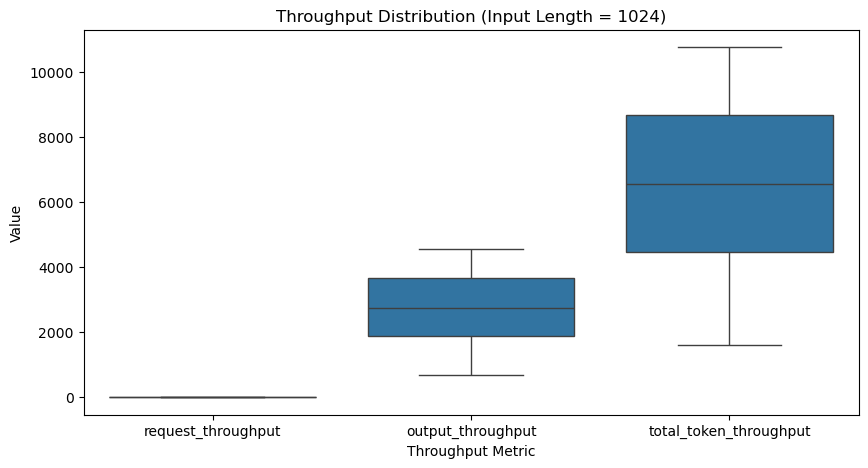

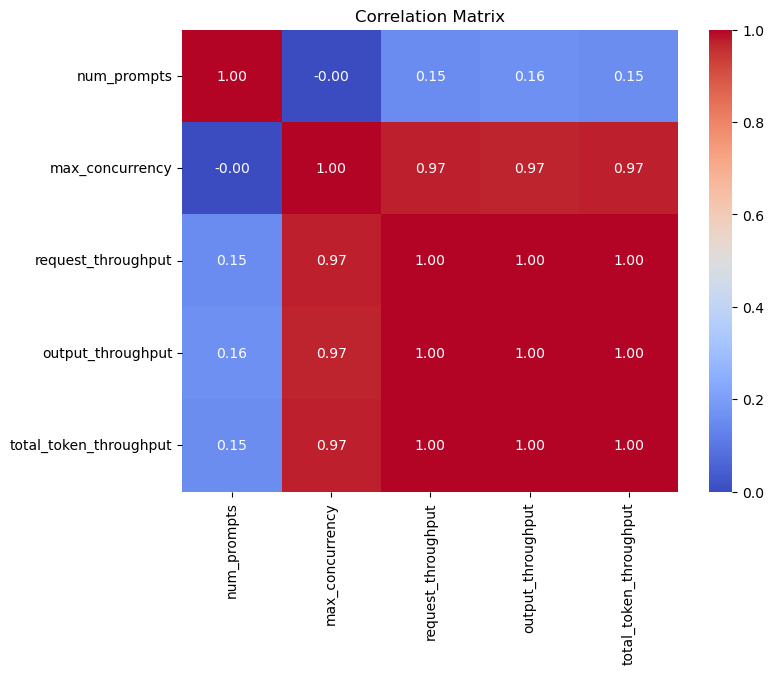

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# 1. JSON 파일 로드
with open('gpu_log/result_DeepSeek-R1-Distill-Llama-70B-20250625-003249_vllm.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data)

# 2. 데이터 전처리
df['input_len'] = df['input_len'].astype(int)
df['output_len'] = df['output_len'].astype(int)
df['request_throughput'] = df['request_throughput'].astype(float)
df['output_throughput'] = df['output_throughput'].astype(float)
df['total_token_throughput'] = df['total_token_throughput'].astype(float)

df['label'] = df['num_prompts'].astype(str) + '_prompts_' + df['max_concurrency'].astype(str) + '_conc'

# 3. Throughput 통계 요약
summary_stats = df[['request_throughput', 'output_throughput', 'total_token_throughput']].describe()
print(summary_stats)

# 4. throughput vs max_concurrency (num_prompts별)
plt.figure(figsize=(15, 5))
for i, metric in enumerate(['request_throughput', 'output_throughput', 'total_token_throughput']):
    plt.subplot(1, 3, i+1)
    sns.lineplot(data=df, x='max_concurrency', y=metric, hue='num_prompts', marker='o')
    plt.title(metric.replace('_', ' ').title())
    plt.xlabel('Max Concurrency')
    plt.ylabel('Throughput')

plt.tight_layout()
plt.show()

# 5. request_throughput vs num_prompts (max_concurrency별)
plt.figure(figsize=(8, 6))
selected_conc = [10, 50, 100]
filtered = df[df['max_concurrency'].isin(selected_conc)]
sns.lineplot(data=filtered, x='num_prompts', y='request_throughput', hue='max_concurrency', marker='o')
plt.title('Request Throughput vs. Number of Prompts')
plt.xlabel('Number of Prompts')
plt.ylabel('Request Throughput')
plt.show()

# 6. Boxplot: throughput 분포
plt.figure(figsize=(10, 5))
melted = df.melt(id_vars=['input_len'], value_vars=[
    'request_throughput', 'output_throughput', 'total_token_throughput'],
    var_name='Throughput Metric', value_name='Value')
sns.boxplot(data=melted, x='Throughput Metric', y='Value')
plt.title('Throughput Distribution (Input Length = 1024)')
plt.show()

# 7. 상관관계 히트맵
plt.figure(figsize=(8, 6))
corr_df = df[['num_prompts', 'max_concurrency', 'request_throughput', 'output_throughput', 'total_token_throughput']]
corr = corr_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()
